# Predicting how well teams will do in March Madness

The goal of this project is use data and computational modeling to predict how well any given team might do in the march madness tournament

## The data
Data was acquired from the following Kaggle project: https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset?resource=download

Column descriptions: 

TEAM: The Division I college basketball school

CONF: The Athletic Conference in which the school participates in (A10 = Atlantic 10, ACC = Atlantic Coast Conference, AE = America East, Amer = American, ASun = ASUN, B10 = Big Ten, B12 = Big 12, BE = Big East, BSky = Big Sky, BSth = Big South, BW = Big West, CAA = Colonial Athletic Association, CUSA = Conference USA, Horz = Horizon League, Ivy = Ivy League, MAAC = Metro Atlantic Athletic Conference, MAC = Mid-American Conference, MEAC = Mid-Eastern Athletic Conference, MVC = Missouri Valley Conference, MWC = Mountain West, NEC = Northeast Conference, OVC = Ohio Valley Conference, P12 = Pac-12, Pat = Patriot League, SB = Sun Belt, SC = Southern Conference, SEC = South Eastern Conference, Slnd = Southland Conference, Sum = Summit League, SWAC = Southwestern Athletic Conference, WAC = Western Athletic Conference, WCC = West Coast Conference)

G: Number of games played

W: Number of games won

ADJOE: Adjusted Offensive Efficiency (An estimate of the offensive efficiency (points scored per 100 possessions) a team would have against the average Division I defense)

ADJDE: Adjusted Defensive Efficiency (An estimate of the defensive efficiency (points allowed per 100 possessions) a team would have against the average Division I offense)

BARTHAG: Power Rating (Chance of beating an average Division I team)

EFG_O: Effective Field Goal Percentage Shot

EFG_D: Effective Field Goal Percentage Allowed

TOR: Turnover Percentage Allowed (Turnover Rate)

TORD: Turnover Percentage Committed (Steal Rate)

ORB: Offensive Rebound Rate

DRB: Offensive Rebound Rate Allowed

FTR : Free Throw Rate (How often the given team shoots Free Throws)

FTRD: Free Throw Rate Allowed

2P_O: Two-Point Shooting Percentage

2P_D: Two-Point Shooting Percentage Allowed

3P_O: Three-Point Shooting Percentage

3P_D: Three-Point Shooting Percentage Allowed

ADJ_T: Adjusted Tempo (An estimate of the tempo (possessions per 40 minutes) a team would have against the team that wants to play at an average Division I tempo)

WAB: Wins Above Bubble (The bubble refers to the cut off between making the NCAA March Madness Tournament and not making it)

POSTSEASON: Round where the given team was eliminated or where their season ended (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)

SEED: Seed in the NCAA March Madness Tournament

YEAR: Season

In [259]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pickle
import seaborn as sns
sns.set_theme()



In [260]:
all_data = pd.read_csv("alldataclean.csv") # data from https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset?resource=download
all_data.drop('BARTHAG', inplace=True, axis=1) # A stat calculated by Bart Torvik that is essentially a metric of 
# how 'good' a team is. It feels like cheating to use it in my models because it is someone else's analysis.
all_data.head()
print(all_data.columns)


Index(['TEAM', 'CONF', 'G', 'W', 'ADJOE', 'ADJDE', 'EFG_O', 'EFG_D', 'TOR',
       'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O', '3P_D',
       'ADJ_T', 'WAB', 'POSTSEASON', 'SEED', 'YEAR'],
      dtype='object')


In [261]:
all_data['WPCT'] = all_data['W'] / all_data['G'] # calculate win percentage
all_data

,TEAM,CONF,G,W,ADJOE,ADJDE,EFG_O,EFG_D,TOR,TORD,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,WPCT
0,Gonzaga,WCC,32,28,120.3,89.9,58.7,43.1,15.7,16.3,...,60.4,41.8,37.0,30.5,72.6,6.7,S16,1.0,2022,0.875000
1,Houston,Amer,38,32,116.5,88.5,53.1,43.3,16.9,21.7,...,54.5,43.4,33.8,28.8,63.7,6.2,E8,5.0,2022,0.842105
2,Kansas,B12,40,34,119.8,91.3,53.8,45.8,17.3,18.1,...,53.6,46.4,36.1,29.8,69.1,10.4,Champions,1.0,2022,0.850000
3,Texas Tech,B12,37,27,110.5,85.4,52.6,45.8,19.8,23.2,...,54.9,44.5,32.1,31.5,66.3,6.6,S16,3.0,2022,0.729730
4,Baylor,B12,34,27,117.8,91.3,52.8,47.8,17.9,22.9,...,53.6,49.2,34.3,30.2,67.6,8.9,R32,1.0,2022,0.794118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155,Michigan St.,B10,35,26,111.4,87.8,50.6,44.5,20.8,19.2,...,50.4,44.3,34.1,30.1,64.4,6.7,S16,3.0,2013,0.742857
3156,Arizona,P12,35,27,114.4,92.2,52.5,46.6,19.5,19.8,...,50.6,43.4,37.1,35.8,66.8,4.6,S16,6.0,2013,0.771429
3157,Oregon,P12,37,28,104.8,88.6,49.3,46.4,21.4,22.0,...,49.1,44.9,33.3,33.4,69.2,2.9,S16,12.0,2013,0.756757
3158,La Salle,A10,34,24,112.0,96.2,51.9,49.3,17.1,21.3,...,49.3,50.6,37.7,30.2,66.0,0.3,S16,13.0,2013,0.705882


In [262]:
all_data['POSTSEASON'].unique()

array(['S16', 'E8', 'Champions', 'R32', 'F4', 'R64', '2ND', nan, 'R68'],
      dtype=object)

In [263]:
all_data.replace({"Champions": 7, "2ND": 6, "F4":5, "E8":4, "S16":3, "R32": 2, "R64": 1, "R68":1, np.nan:0}, inplace=True)
all_data = all_data[all_data['POSTSEASON'] > 0]
tourney_teams = all_data[all_data['POSTSEASON'] > 0]

## Creating a multiple regression linear model

In [264]:
feature_vectors = all_data.drop(['TEAM', 'CONF', 'G', 'W', 'POSTSEASON', 'YEAR'], axis=1)
class_labels = all_data['POSTSEASON']
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vectors, class_labels, random_state=10)

# model = sm.OLS(tourney_teams['POSTSEASON'], tourney_teams[['ADJOE', 'ADJDE', 'EFG_O', 'EFG_D', 'SEED', 'TOR', 'TORD',
#                                          'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O', '3P_D', 'ADJ_T',
#                                          'WAB', 'WPCT']])

# remove non tournament teams from test
# test_df = pd.DataFrame({"vect": list(test_vectors), "lab":list(test_labels)})
test_vectors = test_vectors[test_labels > 0]
test_labels = test_labels[test_labels > 0]

model = sm.OLS(train_labels, train_vectors)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:             POSTSEASON   R-squared (uncentered):                   0.813
Model:                            OLS   Adj. R-squared (uncentered):              0.805
Method:                 Least Squares   F-statistic:                              106.4
Date:                Wed, 27 Apr 2022   Prob (F-statistic):                   9.78e-148
Time:                        14:27:10   Log-Likelihood:                         -651.37
No. Observations:                 459   AIC:                                      1339.
Df Residuals:                     441   BIC:                                      1413.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

For the above regression, basically every numerical stat I had access to was used, and this maybe is a bit too much. Some stats aren't very important or have strong collinearity with other stats. Perhaps those should be eliminated from the model.

In [265]:

train_vectors_less = train_vectors.drop(['ADJOE', 'ADJDE', 'WPCT'], axis=1)
test_vectors_less = test_vectors.drop(['ADJOE', 'ADJDE', 'WPCT'], axis=1)


reduced_model = sm.OLS(train_labels, train_vectors_less)
reduced_results = reduced_model.fit()
print(reduced_results.summary())

                                 OLS Regression Results                                
Dep. Variable:             POSTSEASON   R-squared (uncentered):                   0.787
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              109.5
Date:                Wed, 27 Apr 2022   Prob (F-statistic):                   1.37e-138
Time:                        14:27:10   Log-Likelihood:                         -680.84
No. Observations:                 459   AIC:                                      1392.
Df Residuals:                     444   BIC:                                      1454.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

For my reduced model, I started by taking out some of the advanced metrics, such as as ADJOE and ADJDE. These two advanced metrics are calculated using some advanced math with other stats that we have here, like effective field goal percentages, turnover percentages, and their defensive counterparts. I figured including them was likely significantly contributing to the issue of collinearity, and I was right. I also took out win percentage, because it was also contributing to collinearity. After doing so, the regression adjusted r^2 stayed about the same. However, we may be able to increase it by incorporating what conference the teams are in (because this is a big bart of strength of schedule). It's difficult to include categorical data in this type of model, but I'll include it in other models later.

In [266]:


def analyze_results(pred_labels, test_labels, model_type, classifier=False):
    """
    A function to look at the accuracy of the predictions by looking at the accuracy for each round. It also plots them
    so they can be seen visually.
    paramters: pred_labels - list of predictions
               test_labels - list of actual results
               model_type - string naming the type of model used
               classifier - if the model being tested was a classification model
    """
    comp_tourney = pd.DataFrame({"pred":list(pred_labels), 'actual':list(test_labels)})
    # comp = pd.concat([pred_labels, test_labels], axis=1)
    comp_tourney.columns = ['pred', 'actual']
#     comp_tourney = comp[comp['actual'] > 0].reset_index(drop=True) # I only care about the prediction results of teams that actually made the tournament
    comp_tourney['dif'] = abs(comp_tourney['pred'] - comp_tourney['actual'])
    
    if classifier:
        num_correct = 0
        for i in range(len(comp_tourney)):
            if comp_tourney['pred'][i] == list(comp_tourney['actual'])[i]:
                num_correct += 1

        print("accuracy:", num_correct/len(comp_tourney['pred']))
        print(classification_report(comp_tourney['actual'], comp_tourney['pred']))

        
    print("The mean difference in predicted round vs actual round that teams went to was ", comp_tourney['dif'].mean())
    
    first_round = comp_tourney[comp_tourney['actual'] == 1]
    print("The mean difference in predicted round vs actual round for first round exit teams was", 
          first_round['dif'].mean())

    second_round = comp_tourney[comp_tourney['actual'] == 2]
    print("The mean difference in predicted round vs actual round for second round exit teams was", 
          second_round['dif'].mean())

    third_round = comp_tourney[comp_tourney['actual'] == 3]
    print("The mean difference in predicted round vs actual round for third round exit (sweet 16) teams was", 
          third_round['dif'].mean())

    fourth_round = comp_tourney[comp_tourney['actual'] == 4]
    print("The mean difference in predicted round vs actual round for fourth round exit (elite 8) teams was", 
          fourth_round['dif'].mean())

    fifth_round = comp_tourney[comp_tourney['actual'] == 5]
    print("The mean difference in predicted round vs actual round for fifth round exit (final 4) teams was", 
          fifth_round['dif'].mean())

    sixth_round = comp_tourney[comp_tourney['actual'] == 6]
    print("The mean difference in predicted round vs actual round for sixth round exit (runner up) teams was", 
          sixth_round['dif'].mean())

    seventh_round = comp_tourney[comp_tourney['actual'] == 7]
    print("The mean difference in predicted round vs actual round for championship teams was", 
          seventh_round['dif'].mean())
    
    resultCounter = dict()
    predictions = list(comp_tourney['pred'])
    actuals = list(comp_tourney['actual'])
    sizes = []
    for r in range(len(comp_tourney)):
        actual = actuals[r]
        pred = predictions[r]
        if (pred, actual) not in resultCounter:
            resultCounter[(pred, actual)] = 0
        resultCounter[(pred, actual)] += 1
    for r in range(len(comp_tourney)):
        actual = actuals[r]
        pred = predictions[r]
        sizes.append(resultCounter[(pred, actual)])
    comp_tourney['size'] = sizes
    
    round_nums = [i for i in range(1, 8)]
    mean_difs = [first_round['dif'].mean(), second_round['dif'].mean(), third_round['dif'].mean(), fourth_round['dif'].mean(),
                fifth_round['dif'].mean(), sixth_round['dif'].mean(), seventh_round['dif'].mean()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.subplots_adjust(wspace=0.5)

    fig.suptitle("Pedicting what round a team will make it to with " + model_type)

    im1 = ax1.plot(round_nums, mean_difs)
    ax1.set(xlabel="Actual round team made it to")
    ax1.set(ylabel="Mean absolute value of inaccuracy")
    
    im2 = ax2.scatter(comp_tourney['actual'], comp_tourney['pred'], c=comp_tourney['dif'], s=comp_tourney['size']*20, cmap="cividis")
    ax2.set(xlabel= 'Actual round the team made it to')
    ax2.set(ylabel="Predicted round team made it to")
    fig.colorbar(im2, label='Difference between actual and predicted round')
    


The mean difference in predicted round vs actual round that teams went to was  0.7639874218231075
The mean difference in predicted round vs actual round for first round exit teams was 0.5777147267365705
The mean difference in predicted round vs actual round for second round exit teams was 0.48316735719493087
The mean difference in predicted round vs actual round for third round exit (sweet 16) teams was 0.7388141239413017
The mean difference in predicted round vs actual round for fourth round exit (elite 8) teams was 1.352860618774629
The mean difference in predicted round vs actual round for fifth round exit (final 4) teams was 2.1550903097020933
The mean difference in predicted round vs actual round for sixth round exit (runner up) teams was 2.675736884511918
The mean difference in predicted round vs actual round for championship teams was 3.3597415912111517


/var/folders/xj/ls8gkxtd0bv2xyc2dbbnh81c0000gn/T/ipykernel_6027/3870212590.py:88: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im2, label='Difference between actual and predicted round')


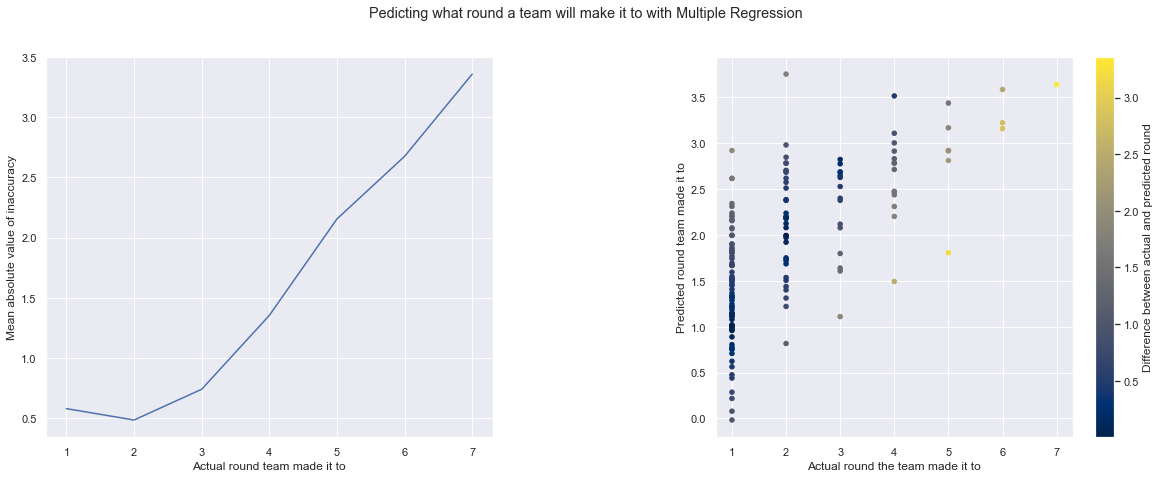

In [267]:
results = reduced_results.predict(test_vectors_less)
analyze_results(results, test_labels, "Multiple Regression")

The multiple regression performed very poorly never even predicted a team to go further than the 2nd round. The model is clearly very flawed.

# Principal Components Analysis

These 8 eigenvectors account for a total of 92 percent of the total variance in the original dataset


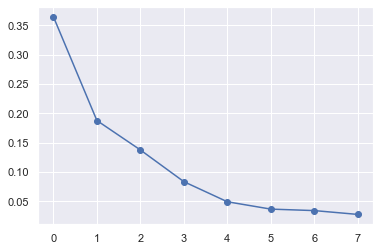

In [268]:
comps = 8
pca = PCA(n_components=comps, whiten=True)
pca.fit(train_vectors)

pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)

plt.plot(pca.explained_variance_ratio_, marker="o")

total_variance = np.sum(pca.explained_variance_ratio_)*100
print("These %d eigenvectors account for a total of %d percent of the total variance in the original dataset"
      % (comps, total_variance))

# Multinomial Logistic Regression

The form of logistic regression we used in class is best for determing guessing a categorical value of an instance of a set of features. It's not great for determining results that list on a spectrum, like I'm looking for. My 'classes' are numbers 0 to 7, with 0 being a team that missed the tournament, 1 being a team that made it, 2, being a team that made it to the next round, all the way up to 7 being a championship-winning team. However, I can use a multinomial logistic regression to classify data that has more than 2 labels. Multinomial logistic regression predicts the possibility of each of the classes, and then chooses the one with the highest probability.

accuracy: 0.5751633986928104
              precision    recall  f1-score   support

           1       0.71      0.90      0.79        79
           2       0.32      0.31      0.32        35
           3       0.30      0.20      0.24        15
           4       0.33      0.14      0.20        14
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         3
           7       0.50      1.00      0.67         1

    accuracy                           0.58       153
   macro avg       0.31      0.37      0.32       153
weighted avg       0.50      0.58      0.53       153

The mean difference in predicted round vs actual round that teams went to was  0.6666666666666666
The mean difference in predicted round vs actual round for first round exit teams was 0.11392405063291139
The mean difference in predicted round vs actual round for second round exit teams was 0.8285714285714286
The mean difference in predicted round vs actual round for third

/Users/ajb/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ajb/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ajb/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/xj/ls8gkxtd0

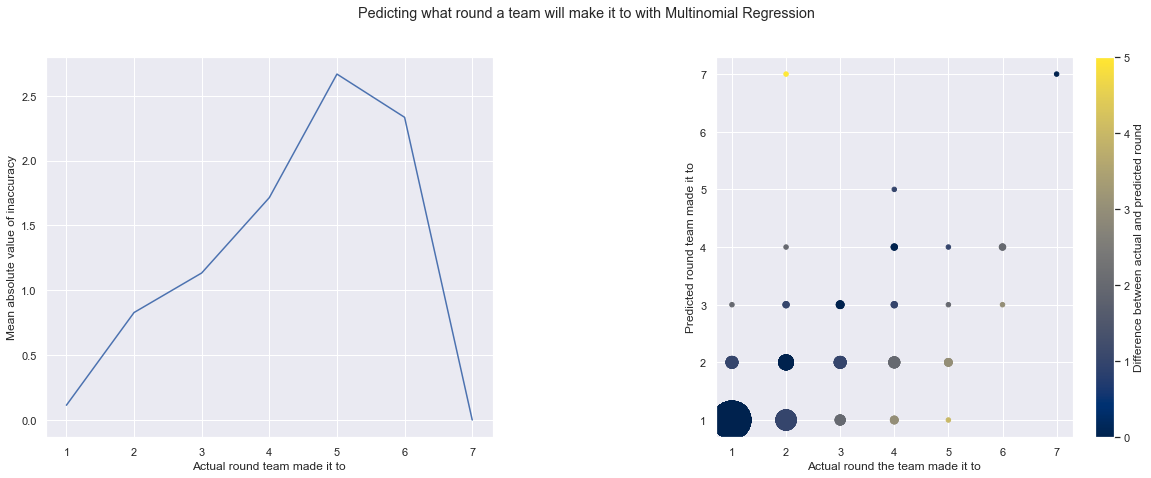

In [269]:
mults = [-2, -1, 0, 1, 2]
bestC = None
bestDif = 13
for m in mults: # determine the C value that minimizes error
    c = 10**m
    multinomialModel = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000, C=c)

    multinomialModel.fit(pca_train_vectors, train_labels)

    pred_labels = multinomialModel.predict(pca_test_vectors)
    
    comp_tourney = pd.DataFrame({"pred":list(pred_labels), 'actual':list(test_labels)})
    comp_tourney.columns = ['pred', 'actual']
    comp_tourney['dif'] = abs(comp_tourney['pred'] - comp_tourney['actual'])
    dif = comp_tourney['dif'].mean()
    if dif < bestDif:
        bestDif = dif
        bestC = c
        
# make the model with the best c I found
multinomialModel = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000, C=bestC)
multinomialModel.fit(pca_train_vectors, train_labels)
pred_labels = multinomialModel.predict(pca_test_vectors)        
    

analyze_results(pred_labels, test_labels, "Multinomial Regression", classifier=True)

In [270]:
bestC

10

As you can see, the model is pretty good at predicting the teams that would exit in the first 2 rounds. After this, the model starts to guess incorrectly by an average of more than 1 round. It gets harder later to predict teams that will make it later because there are more games to play to get there and thus more variance. However, I am still quite pleased with this model's results.

# Now with conferences

I tried next remaking the same model, but using the conferences as a part of it. This required making new columns for each conference, and making the value 0 or a constant in each row depending on if that team were in the conference. I had to leave out the uncommon conferences and use 20 for my constant instead of 1, or the variance would be too low and I'd have a singular matrix.

In [271]:
uncommon = []
for conf in all_data['CONF'].unique():
    count = all_data['CONF'].str.count(conf).sum()
    if count < 10: # if we have a total of less than 10 teams make the tourney from a conference across all the years
        uncommon.append(conf)
        

sep_data=all_data.replace({c:"UNCOMMON" for c in uncommon}) # lump all the uncommon conferences together
sep_data = sep_data[all_data['CONF'] != "UNCOMMON"] # get ride of it. We can't analyze it because there are too few

sep_data = pd.concat((sep_data, pd.get_dummies(sep_data['CONF'])), axis=1)
for c in sep_data['CONF'].unique():
    sep_data[c] = sep_data[c].replace(1, 20)
    
feature_vectors = sep_data.drop(['TEAM', 'CONF', 'G', 'W', 'POSTSEASON', 'YEAR'], axis=1)
class_labels = sep_data['POSTSEASON']
train_vectors_conf, test_vectors_conf, train_labels, test_labels = train_test_split(feature_vectors, class_labels, random_state=10)

multinomialModel = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000,C=10)

multinomialModel.fit(train_vectors_conf, train_labels)

pred_labels = multinomialModel.predict(test_vectors_conf)


accuracy: 0.5359477124183006
              precision    recall  f1-score   support

           1       0.72      0.84      0.77        79
           2       0.37      0.29      0.32        35
           3       0.27      0.20      0.23        15
           4       0.25      0.21      0.23        14
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1

    accuracy                           0.54       153
   macro avg       0.23      0.22      0.22       153
weighted avg       0.50      0.54      0.52       153

The mean difference in predicted round vs actual round that teams went to was  0.7712418300653595
The mean difference in predicted round vs actual round for first round exit teams was 0.25316455696202533
The mean difference in predicted round vs actual round for second round exit teams was 1.1428571428571428
The mean difference in predicted round vs actual round for third

/var/folders/xj/ls8gkxtd0bv2xyc2dbbnh81c0000gn/T/ipykernel_6027/3870212590.py:88: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im2, label='Difference between actual and predicted round')


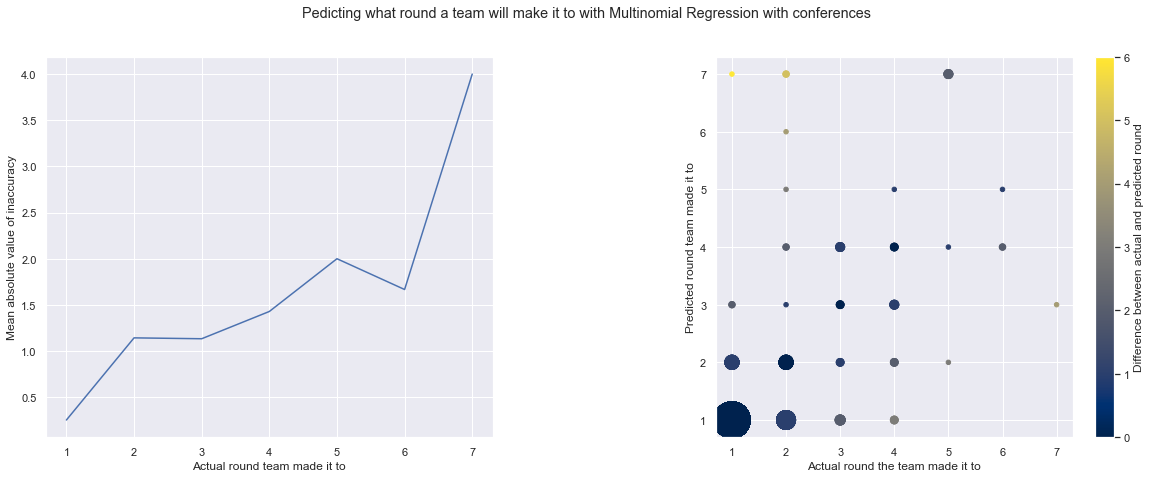

In [272]:
analyze_results(pred_labels, test_labels, "Multinomial Regression with conferences", classifier=True)

In the end, using the teams conferences in my logistic regression model ended up making the model slightly worse.

# SVM

The SVM model above ended up using a C value of 10000, which is pretty high. Higher C values make the model adjust to fit itself to classify outliers correctly. In the tournament there are always going to be tons out outliers, and its impossible to predict them all. So while a higher C value gets more correct classifications, its possible that its causing the incorrect classifications to be more incorrect than they otherwise would be. For example, giving a team that makes the Final 4 (classification 5) a classification of 2 is worse than giving it a classification of 4. This is due to the fact that our classifcations exist on a spectrum and, in some ways, it can be useful to treat them as discrete variables. If you were filling out a bracket, it would be better to have a team make it just a little further in the tournament than you thought rather than a lot further. Using a lower C may help account for that, which is what is attempted below.

In [273]:

trained = False

if not trained:
    print("Fitting the classifier to the training set")
#     param_grid = {'C': [.01, .1, 1, 10, 1e3, 5e3, 1e4, 5e4, 1e5],
#                   'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
#                   'kernel': ['linear', 'rbf']}
    param_grid = {'C': [.01, .1, 1, 10, 25, 100],
                  'gamma': [.001, .01, .1, 1],
                  'kernel': ['linear', 'rbf']}
    clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, n_jobs=-1)
    clf = clf.fit(pca_train_vectors, train_labels)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    #save the model to a file
    pickle.dump(clf, open('svm_model_pca.p', 'wb'))
    trained = True

else:
    #read the model from a file
    print("reading pickle file.")
    clf = pickle.load(open('svm_model_pca.p', 'rb'))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)


# Quantitative evaluation of the model quality on the test set

print("Predicting round teams will make it to with 8 features")
pred_labels = clf.predict(pca_test_vectors)


Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1, class_weight='balanced', gamma=1)
Predicting round teams will make it to with 8 features


accuracy: 0.5294117647058824
              precision    recall  f1-score   support

           1       0.53      1.00      0.69        79
           2       0.00      0.00      0.00        35
           3       0.50      0.13      0.21        15
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1

    accuracy                           0.53       153
   macro avg       0.15      0.16      0.13       153
weighted avg       0.32      0.53      0.38       153

The mean difference in predicted round vs actual round that teams went to was  0.954248366013072
The mean difference in predicted round vs actual round for first round exit teams was 0.0
The mean difference in predicted round vs actual round for second round exit teams was 1.0
The mean difference in predicted round vs actual round for third round exit (sweet 16) teams was

/Users/ajb/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ajb/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ajb/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/xj/ls8gkxtd0

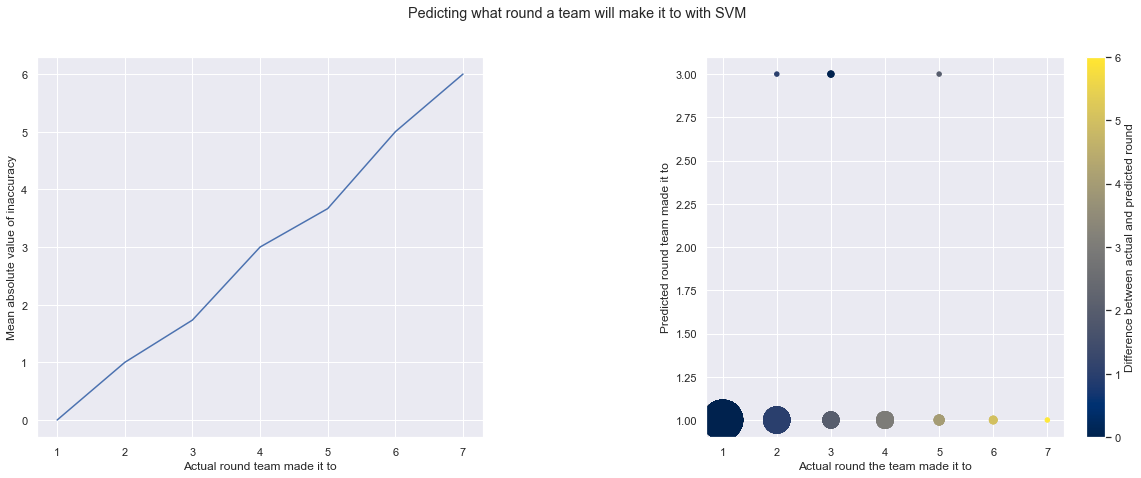

In [274]:
analyze_results(pred_labels, test_labels, "SVM", classifier=True)

It appears the SVM had a lot of trouble classifying the teams as it classified almost all of them as teams that would exit in the first round.

# How did my model do?

I found that the average bracket in 2018 (most recent year I could find average scoring info for) scored 57 using the scoring system of 1 point for predicting a first round win, 2 for predicting a second round win, 4 for a sweet 16 win, 8 for an elite 8 win, 16 for final four win, and 32 for championship win. This is how sites like ESPN and NCAA.com score brakcets. I will pick my bracket by having the team with the higher classification value from my multinomial logistic regression win each game. In the event of a tie, I will give the win to the team with the higher multiple regression value.

In [275]:
train = all_data[all_data['YEAR'] != 2018]
test = all_data[all_data['YEAR'] == 2018]

train = train[train['POSTSEASON'] > 0]
train_vectors = train.drop(['TEAM', 'CONF', 'G', 'W', 'POSTSEASON', 'YEAR'], axis=1)
train_labels = train['POSTSEASON']

test = test[test['POSTSEASON'] > 0]
test_vectors = test.drop(['TEAM', 'CONF', 'G', 'W', 'POSTSEASON', 'YEAR'], axis=1)


In [276]:
multinomialModel = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=10000, C=10)
multinomialModel.fit(train_vectors, train_labels)
log_labels = multinomialModel.predict(test_vectors)

reg_model = sm.OLS(train_labels, train_vectors)
reg_results = reg_model.fit()
reg_labels = reg_results.predict(test_vectors)

In [277]:
results = pd.DataFrame({"TEAM": test['TEAM'], 'LOG':log_labels, 'REG': reg_labels})
results = results.sort_values(by=['LOG', "REG"], ascending = False)
pd.set_option('display.max_rows', 68)
results

,TEAM,LOG,REG
716,Villanova,7,3.851144
723,Duke,3,3.499732
751,Kansas,3,3.154581
707,Michigan,3,2.889408
2815,Florida,3,2.715728
3138,Kentucky,3,2.611729
2912,Creighton,3,1.802185
2783,Butler,3,1.590153
2756,Cincinnati,2,2.986156
3120,Purdue,2,2.953181


Now that I have my data, I'll filled out a bracket over the final bracket of what actually happened in 2018. My models picks are in red, and picks circled in green were correct. The text on the image in black is what actually happened.

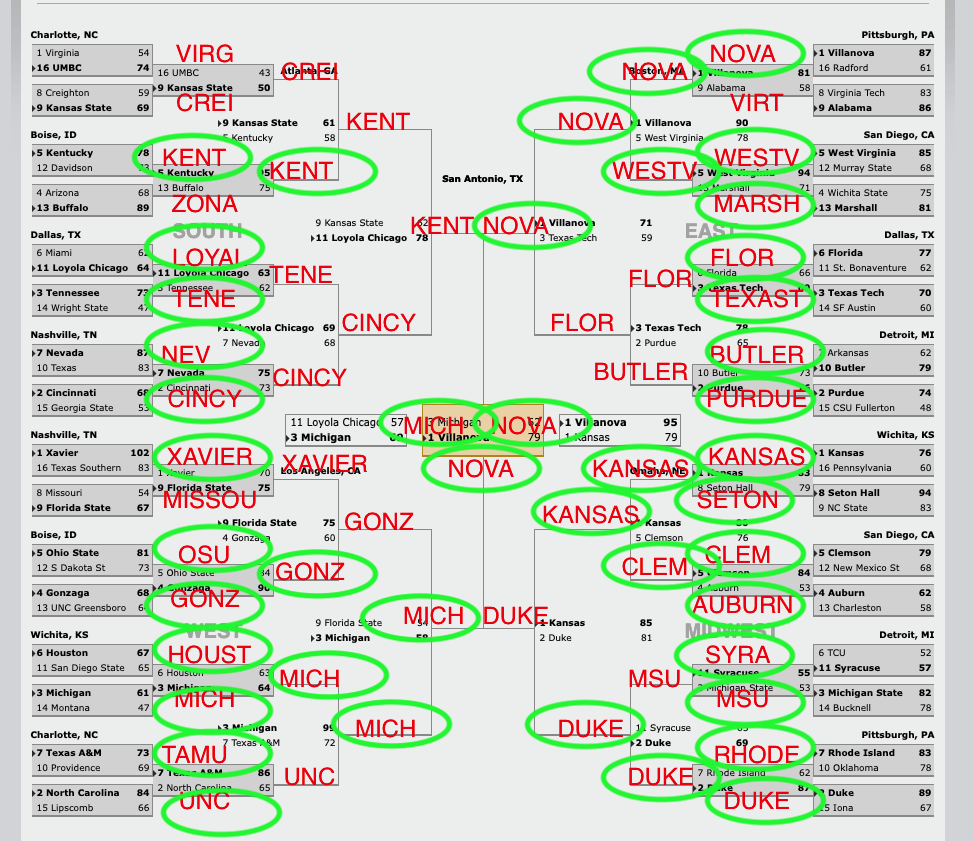

In [278]:
from IPython import display
display.Image("./2018bracket.png")

As you can see, the model performed pretty well. It picked both championship teams correctly as well as the winner, and it got a staggering 27/32 first round picks correct. Tallying up the point totals, my model's bracket scored a remarkable 139 points! The average score for brackets in 2018 was 57, and a score of 139 put us in roughly the 98th percentile among all brackets on NCAA.com! I would love to score my brackets in more years, but I don't have a way to program it to automate it because I don't have matchup data, so I have to do it by hand. Its a relatively time consuming process, so I'm only doing it for this one year.

Despite only correctly classifying the teams correctly around 52% of the time, it is still incredibly good at predicting winners when using its classifications as a form of ranking for head to head matchups.